In [134]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(0, 2)
qc.draw()

q_0: ──■─────────■──
     ┌─┴─┐       │  
q_1: ┤ X ├──■────┼──
     └───┘┌─┴─┐┌─┴─┐
q_2: ─────┤ X ├┤ X ├
          └───┘└───┘

In [135]:
# pass manager is given dag, so use this as input to our mock functions
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qc)

In [136]:
# looking up index of a qubit in the circuit
for node in dag.topological_op_nodes():
    print([QuantumCircuit.find_bit(qc, arg).index for arg in node.qargs])

[0, 1]
[1, 2]
[0, 2]


In [137]:
# basic cost function
from qiskit.converters import dag_to_circuit


def get_cost(dag, layout):
    qc = dag_to_circuit(dag)
    cost = 0
    for node in dag.topological_op_nodes():
        bit_indices = [QuantumCircuit.find_bit(qc, arg).index for arg in node.qargs]
        # convert to physical qubit indices
        physical_indices = [layout[bit_index] for bit_index in bit_indices]
        # get the topological distance
        distance = abs(physical_indices[0] - physical_indices[1]) - 1
        cost += distance
    return cost


layout = {0: 0, 1: 1, 2: 2}
get_cost(dag, layout)

1

In [138]:
# cost function that updates layout on marked nodes
# mark the first op node in the dag with a new attribute
dag.op_nodes()[1].name = "cx_m"

In [139]:
# cost function that updates layout on marked nodes
from qiskit.converters import dag_to_circuit

"""Use physical_indices here, but note that this changes dynamical with the topological order of the circuit.
This means make sure don't lose the initial layout and discard the physical_indices at end.
"""


def get_updated_cost(dag, layout):
    qc = dag_to_circuit(dag)
    cost = 0
    for node in dag.topological_op_nodes():
        bit_indices = [QuantumCircuit.find_bit(qc, arg).index for arg in node.qargs]
        # convert to physical qubit indices
        physical_indices = [layout[bit_index] for bit_index in bit_indices]
        # get the topological distance
        distance = abs(physical_indices[0] - physical_indices[1]) - 1
        cost += distance

        # update layout if marked node
        if node.name == "cx_m":
            layout[bit_indices[0]], layout[bit_indices[1]] = (
                layout[bit_indices[1]],
                layout[bit_indices[0]],
            )

    return cost


layout = {0: 0, 1: 1, 2: 2}
get_updated_cost(dag, layout)

0

In [140]:
for node in dag.two_qubit_ops():
    print(node.name)

cx
cx_m
cx


In [145]:
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    Unroller,
    TrivialLayout,
    ApplyLayout,
    SabreLayout,
    CountOpsLongestPath,
)
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
import numpy as np

from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

# this code is buggy, see https://github.com/Qiskit/qiskit-terra/pull/9375
# I can't use this version bc qiskit version missing DAGCircuit functionality

# build a toffoli
qc = QuantumCircuit(8)
qc.ccx(0, 1, 2)
qc.cx(1, 7)
qc.ccx(3, 4, 5)
qc.ccx(2, 5, 6)
# build a 2x2 square coupling map
coupling = CouplingMap.from_line(8)

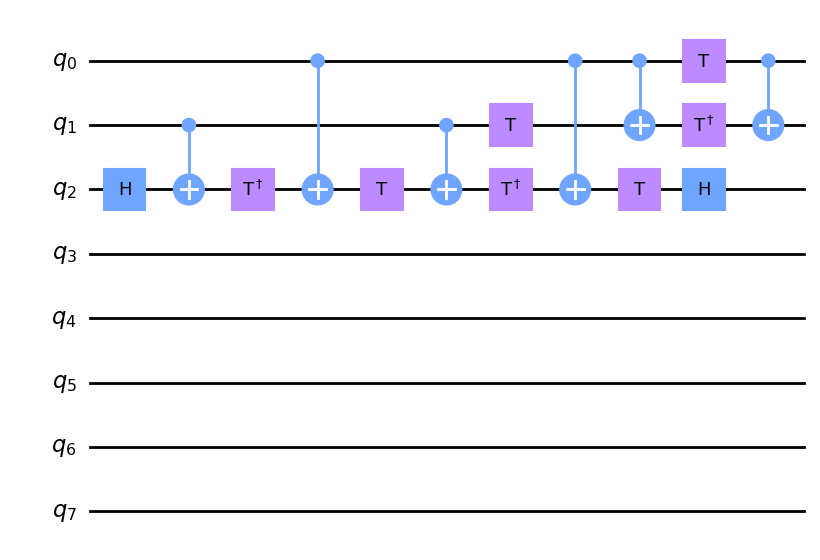

In [142]:
qc.decompose().draw(output="mpl")

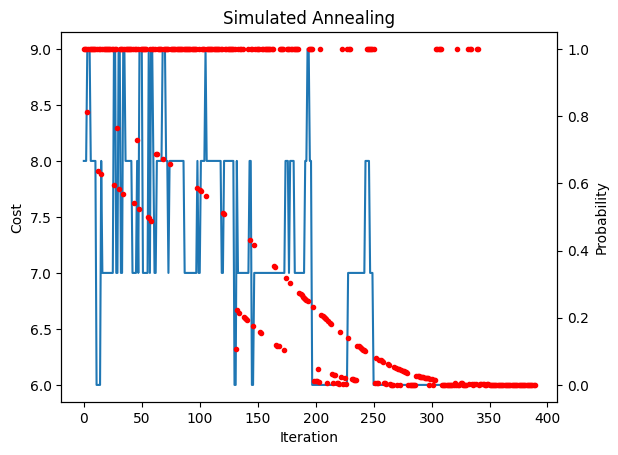

here
here
Gate count: 12
Longest path gate count: 12


In [143]:
from virtual_swap.vswap_simple import VirtualSwap

# run the pass
pm = PassManager()
# need some basic unroll and layout
pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
pm.append(VirtualSwap(coupling, visualize=True))
pm.append(OptimizeSwapBeforeMeasure())

# XXX use the PR version once merged into Qiskit
# pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
pm.append([CountOpsLongestPath()])

# set debug logging
# import logging

# logger = logging.getLogger("VSWAP")
# logger.setLevel(logging.INFO)

new_circ = pm.run(qc)

# sum the cost of gate 'cx' and 'iswap'
print(
    f"Gate count:", 2 * new_circ.count_ops()["iswap"] + 2 * new_circ.count_ops()["cx"]
)
longest_path = pm.property_set["count_ops_longest_path"]
print(f"Longest path gate count:", 2 * longest_path["iswap"] + 2 * longest_path["cx"])

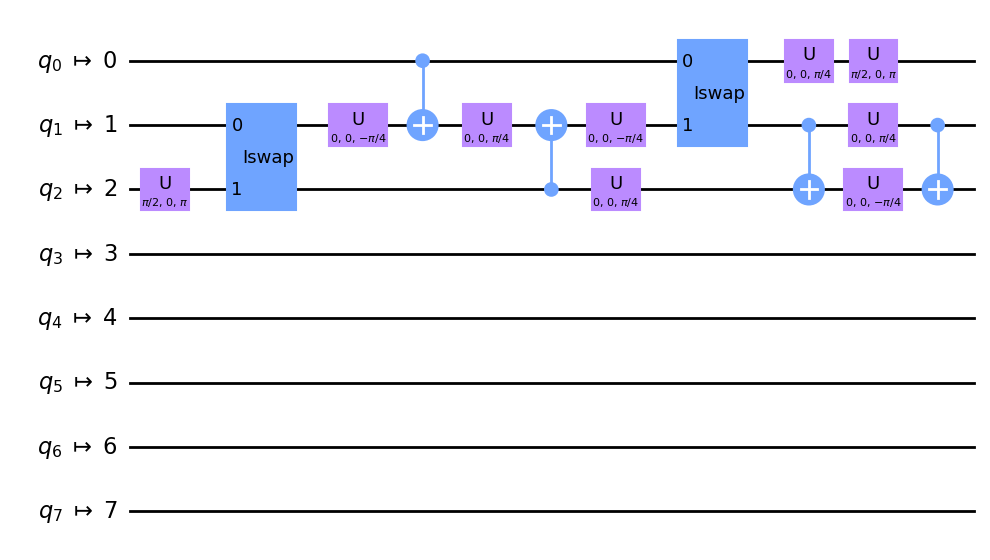

In [144]:
new_circ.draw(output="mpl")